In [1]:
%tensorflow_version 2.x
!pip install -q keras==2.3.0

TensorFlow 2.x selected.
     |████████████████████████████████| 378kB 3.5MB/s 


In [2]:
from keras.applications import vgg19
from keras.preprocessing import image as kimage
from keras.models import Model, load_model
from keras import optimizers, layers, losses, callbacks


import numpy as np

import tarfile

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Import Dataset

In [3]:
!wget https://www.dropbox.com/s/drwy7fq5svwv78p/101_ObjectCategories_split.tar

--2020-01-30 13:25:19--  https://www.dropbox.com/s/drwy7fq5svwv78p/101_ObjectCategories_split.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/drwy7fq5svwv78p/101_ObjectCategories_split.tar [following]
--2020-01-30 13:25:19--  https://www.dropbox.com/s/raw/drwy7fq5svwv78p/101_ObjectCategories_split.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb3685fdf396e98af180c3ab08b.dl.dropboxusercontent.com/cd/0/inline/AxIdPNuAjwWR4JuGuqPDpz1aJ16nkS1IKtS3yF-L-Nhz0FMOUDjUmFGAs_jhY4vFoLt4h7afWkpbk4KcV0Dm2Dg3Kh1GNiUpgqRHCxlhfT7VTg/file# [following]
--2020-01-30 13:25:19--  https://ucb3685fdf396e98af180c3ab08b.dl.dropboxusercontent.com/cd/0/inline/AxIdPNuAjwWR4JuGuqPDpz1aJ16nkS1IKtS3yF-L-Nhz0FMOUDjUmFGAs_jhY4vFoLt4h7afWkpbk4KcV

In [0]:
# Estrazione dati
tar = tarfile.open("101_ObjectCategories_split.tar")
tar.extractall()
tar.close()
!rm 101_ObjectCategories_split.tar

## Train set

In [0]:
train_processing = kimage.ImageDataGenerator(preprocessing_function=vgg19.preprocess_input) # Prerocessing utilizzato da vgg19

In [38]:
# Applicazione del preprocessing al train set

train_generator = train_processing.flow_from_directory(
        directory = "/content/101_ObjectCategories_split/train",
        target_size = (224, 224),
        color_mode = "rgb",
        batch_size = 32,
        class_mode = "categorical",
        shuffle = True,
        seed=1
)

Found 4600 images belonging to 102 classes.


## Test set

In [39]:
# Applicazione del preprocessing al train set

test_processing = kimage.ImageDataGenerator(preprocessing_function=vgg19.preprocess_input)

test_generator = test_processing.flow_from_directory(
        directory = "/content/101_ObjectCategories_split/test",
        target_size = (224, 224),
        color_mode = "rgb",
        batch_size = 32,
        class_mode = "categorical",
        shuffle = True
)

Found 4544 images belonging to 102 classes.


# Caricamento modello

Il modello scelto è la vgg19 con i pesi di imagenet

In [0]:
vgg_base = vgg19.VGG19(input_shape = (224, 224, 3),
                                    weights = "imagenet", 
                                    include_top = False,
                                    pooling = "avg")

In [0]:
# Blocco dell'apprendimento dei layer

for layer in vgg_base.layers: 
    layer.trainable = False

In [52]:
vgg_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Modifica del modello e fit di esso

In [53]:
# Si aggiungono dei layer di specializzazione per l'obiettivo preso in consideraione: 
# due layers Dense da 1024 e due Dropout, infine il layer di classificazione

x = vgg_base.output
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
pred = layers.Dense(102, activation='softmax')(x)

net = Model(input = vgg_base.input, output = pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


In [0]:
# Early Stopping per evitare l'overfit del modello e stoppare le epoche in automatico

es = callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

In [0]:
net.compile(loss=losses.categorical_crossentropy,
            optimizer=optimizers.adam(),
              metrics=['accuracy'])

In [56]:
# Training del modello

history = net.fit_generator(train_generator, 
                            epochs = 100, 
                            validation_data = test_generator,
                            callbacks = [es])

Epoch 1/100
144/144 [==============================] - 51s 353ms/step - loss: 2.9834 - accuracy: 0.4733 - val_loss: 1.0717 - val_accuracy: 0.7832
Epoch 2/100
144/144 [==============================] - 52s 359ms/step - loss: 1.1853 - accuracy: 0.7139 - val_loss: 0.6734 - val_accuracy: 0.8330
Epoch 3/100
144/144 [==============================] - 52s 363ms/step - loss: 0.9110 - accuracy: 0.7696 - val_loss: 1.0410 - val_accuracy: 0.8382
Epoch 4/100
144/144 [==============================] - 53s 370ms/step - loss: 0.6684 - accuracy: 0.8259 - val_loss: 0.4814 - val_accuracy: 0.8578
Epoch 5/100
144/144 [==============================] - 54s 377ms/step - loss: 0.6283 - accuracy: 0.8426 - val_loss: 1.2333 - val_accuracy: 0.8422
Epoch 6/100
144/144 [==============================] - 55s 380ms/step - loss: 0.5475 - accuracy: 0.8602 - val_loss: 0.4105 - val_accuracy: 0.8578
Epoch 7/100
144/144 [==============================] - 55s 379ms/step - loss: 0.5236 - accuracy: 0.8711 - val_loss: 0.7812 -

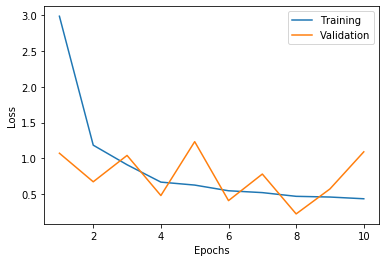

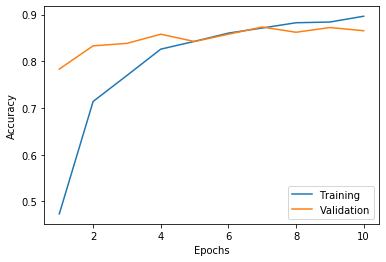

In [57]:
x_plot = list(range(1,history.epoch[-1]+2))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'])

    
plot_history(history)

La rete neurale raggiunge risultati migliori rispetto alla MobileNetv2 con i dati originali

# Data Augmentation

In [0]:
# Creazione dell'oggetto per data Augmentation

datagen = kimage.ImageDataGenerator(preprocessing_function=vgg19.preprocess_input,
                                    rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

## Train e test

In [32]:
# Applicazione data augmentation SOLO sul train set
train_generator_aug = datagen.flow_from_directory(directory = "/content/101_ObjectCategories_split/train",
                                                  target_size = (224, 224),
                                                  color_mode = "rgb",
                                                  batch_size = 32,
                                                  class_mode = "categorical",
                                                  shuffle = True,
                                                  seed=1)

Found 4600 images belonging to 102 classes.


'# Applicazione data augmentation sul test set\ntest_generator_aug = datagen.flow_from_directory(directory = "/content/101_ObjectCategories_split/test",\n                                                 target_size = (224, 224),\n                                                 color_mode = "rgb",\n                                                 batch_size = 32,\n                                                 class_mode = "categorical",\n                                                 shuffle = True,\n                                                 seed=1)'

Ricompilo e fitto lo stesso modello con i dati creati 

In [58]:
x = vgg_base.output
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
pred = layers.Dense(102, activation='softmax')(x)

net = Model(input = vgg_base.input, output = pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [0]:
net.compile(loss=losses.categorical_crossentropy,
            optimizer=optimizers.adam(),
              metrics=['accuracy'])

In [60]:
history_aug = net.fit_generator(train_generator_aug, 
                            epochs = 100, 
                            validation_data = test_generator,
                            callbacks = [es])

Epoch 1/100
144/144 [==============================] - 86s 600ms/step - loss: 3.3528 - accuracy: 0.3748 - val_loss: 1.1973 - val_accuracy: 0.7058
Epoch 2/100
144/144 [==============================] - 81s 565ms/step - loss: 1.8222 - accuracy: 0.5657 - val_loss: 0.9444 - val_accuracy: 0.7718
Epoch 3/100
144/144 [==============================] - 83s 577ms/step - loss: 1.4772 - accuracy: 0.6309 - val_loss: 0.1939 - val_accuracy: 0.7975
Epoch 4/100
144/144 [==============================] - 83s 575ms/step - loss: 1.2339 - accuracy: 0.6878 - val_loss: 0.8522 - val_accuracy: 0.8140
Epoch 5/100
144/144 [==============================] - 82s 572ms/step - loss: 1.1729 - accuracy: 0.7089 - val_loss: 0.9132 - val_accuracy: 0.8471


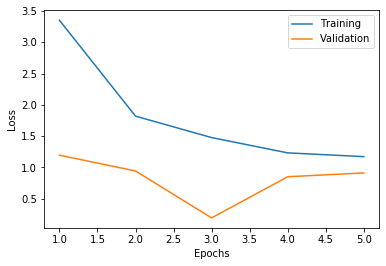

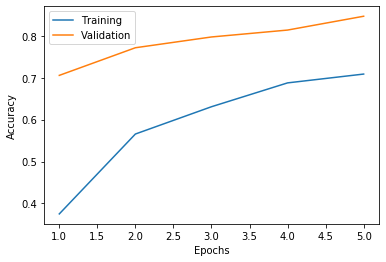

In [61]:
x_plot = list(range(1,history_aug.epoch[-1]+2))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'])

    
plot_history(history_aug)

I risultati ottenuti dalla rete con i dati augmentato sono leggermente inferiori rispetto a quelli con i dati originali.